In [1]:
import sys
#%pdb
import gym
import copy
import pickle
import random
%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import filter_env
from ou_noise import OUNoise
from replay_buffer import ReplayBuffer # <- has setting to either get constant batches (most recent exp), or random batches
import tensorflow as tf
import math
import ddpg_tf # tf net
import gc
gc.enable()
np.core.arrayprint._line_width = 120

actor not using batch norm!!


In [2]:
# Hyperparameters/Settings
SEED = 5

LOAD_NET = False
USE_TF_PARAMS = None #'tf_params-0' # path of tf save checkpoint
PATH_ROOT = 'save/'

ENV_NAME = 'Pendulum-v0' #'InvertedPendulum-v1'
EPISODES = 120
TEST = 10
TEST_STEP = 2 #100

ACTOR_BN = False
LAYER1_SIZE = 400
LAYER2_SIZE = 300
LEARNING_RATE = 1e-3
L2 = 0.01
TAU = 0.001
BATCH_SIZE = 64

REPLAY_BUFFER_SIZE = 5000 #200 #1000000
REPLAY_START_SIZE = 500 #50 #10000
GAMMA = 0.99

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
pass


In [3]:
# ignore
# functions for replacing torch params with tf params
param_translation = {#'actor.layer0_bn.bias':'batch_norm_0/beta:0',
                    #'actor.layer0_bn.weight':'batch_norm_0/gamma:0',
                    'actor.layer1.bias':'actorb1:0',
                    'actor.layer1.weight':'actorW1:0',
                    #'actor.layer1_bn.bias':'batch_norm_1/beta:0',
                    #'actor.layer1_bn.weight':'batch_norm_1/gamma:0',
                    'actor.layer2.bias':'actorb2:0',
                    'actor.layer2.weight':'actorW2:0',
                    #'actor.layer2_bn.bias':'batch_norm_2/beta:0',
                    #'actor.layer2_bn.weight':'batch_norm_2/gamma:0',
                    'actor.output_layer.bias':'actorb3:0',
                    'actor.output_layer.weight':'actorW3:0',
                    'critic.action_layer.weight':'critic_W2a:0',
                    'critic.layer1.bias':'critic_b1:0',
                    'critic.layer1.weight':'critic_W1:0',
                    'critic.layer2.bias':'critic_b2:0',
                    'critic.layer2.weight':'critic_W2:0',
                    'critic.output_layer.bias':'critic_b3:0',
                    'critic.output_layer.weight':'critic_W3:0'}

def replaceNetParams(tf_net, torch_net, torch_target_net=None):
    
    #torch_vars = dict(torch_net.state_dict())
    
    tf_vars = dict([(str(v.name),v) for v in dtf.all_vars])
    for name, param in torch_net.named_parameters():
        param.data.copy_(torch.Tensor(tf_vars[param_translation[str(name)]].eval().T).float())
        
    if torch_target_net is not None:
        for name, param in torch_target_net.named_parameters():
            param.data.copy_(torch.Tensor(tf_vars[param_translation[str(name)][:-2]+'/ExponentialMovingAverage:0'].eval().T).float())
    
    #for torch_key, tf_key in param_translation.items():
    #    torch_vars[torch_key].copy_(torch.Tensor(tf_vars[tf_key].eval().T))
        #print torch_key, 'copied successfully'

def run_control_data(test_net, get_actions=False):
    control_data = np.load('control_states.npy')
    data = torch.from_numpy(control_data).float()
    test_net.eval()
    if get_actions:
        return test_net.getActions(Variable(data)).data # returns action predictions
    return test_net(Variable(data)).data # returns value predictions

In [4]:
# torch net definitions
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCriticNet, self).__init__()

        self.actor = ActorNet(state_dim, action_dim)
        self.critic = CriticNet(state_dim, action_dim)

    def forward(self, state):
        action = self.actor(state)
        value = self.critic(state, action)
        return value

    def getAction(self, state):
        return self.actor(state)

    def getValue(self, state, action=None):
        if action is None:
            return self.critic(state, self.actor(state))
        return self.critic(state, action)

    #def train(self): # might not be necessary
    #    self.critic.train()
    #    self.actor.train()
    
    #def eval(self): # might not be necessary
    #    self.critic.eval()
    #    self.actor.eval()

class CriticNet(nn.Module):

    def __init__(self, state_dim, action_dim):
        super(CriticNet, self).__init__()

        # make sure all params are initizialized randomly [-1/np.sqrt(dim),1/np.sqrt(dim)]
        self.layer1 = nn.Linear(state_dim,LAYER1_SIZE)
        self.action_layer = nn.Linear(action_dim,LAYER2_SIZE,bias=False)
        self.layer2 = nn.Linear(LAYER1_SIZE,LAYER2_SIZE)
        self.output_layer = nn.Linear(LAYER2_SIZE,1)

    def forward(self, state, action):
        x = F.relu(self.layer1(state))
        x = F.relu(self.action_layer(action) + self.layer2(x))
        q = self.output_layer(x)
        return q # predicted q value of this state-action pair

class ActorNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNet, self).__init__()

        # make sure all params are initizialized randomly [-1/np.sqrt(dim),1/np.sqrt(dim)]
        if ACTOR_BN: self.layer0_bn = nn.BatchNorm1d(state_dim,affine=False)
        self.layer1 = nn.Linear(state_dim,LAYER1_SIZE)
        if ACTOR_BN: self.layer1_bn = nn.BatchNorm1d(LAYER1_SIZE,affine=False)
        self.layer2 = nn.Linear(LAYER1_SIZE,LAYER2_SIZE)
        if ACTOR_BN: self.layer2_bn = nn.BatchNorm1d(LAYER2_SIZE,affine=False)
        self.output_layer = nn.Linear(LAYER2_SIZE,action_dim)

    def forward(self, state):
        if ACTOR_BN: state = F.relu(self.layer0_bn(state))
        x = self.layer1(state)
        if ACTOR_BN: x = self.layer1_bn(x)
        x = F.relu(x)
        x = self.layer2(x)
        if ACTOR_BN: x = self.layer2_bn(x)
        x = F.relu(x)
        action = F.tanh(self.output_layer(x))
        return action # predicted best actions

In [5]:
# reset torch net and env
env = filter_env.makeFilteredEnv(gym.make(ENV_NAME))
state_dim = env.observation_space.shape[0]
action_dim =  env.action_space.shape[0]

stats = {'losses':[], 'losses_ep':[], 'rewards':[], 'rewards_ep':[]}
total_episodes = 0

if not LOAD_NET:
    net = ActorCriticNet(state_dim,action_dim)
    
    if USE_TF_PARAMS is not None:
        dtf = ddpg_tf.DDPG_TF(env,loadfilename=USE_TF_PARAMS,printVars=False)
        replaceNetParams(net,dtf)
        print 'using tensorflow parameters from file:', USE_TF_PARAMS
    
    target_net = copy.deepcopy(net)
    memory = ReplayBuffer(REPLAY_BUFFER_SIZE)
    noise = OUNoise(action_dim)
else:
    net = torch.load(PATH_ROOT + 'saved_net')
    target_net = torch.load(PATH_ROOT + 'saved_target_net')
    memory = pickle.load(file(PATH_ROOT +'saved_memory','r'))
    noise = pickle.load(file(PATH_ROOT +'saved_noise','r'))
    for n in stats:
        stats[n] = np.load(PATH_ROOT + n + '.npy').tolist()
    total_episodes = stats['losses_ep'][-1] if len(stats['losses_ep']) else 0


    
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=L2)
target_optim = optim.Optimizer(target_net.parameters(), {}) # to iterate over target params


[2017-08-16 09:35:42,411] Making new env: Pendulum-v0


True action space: [-2.], [ 2.]
True state space: [-1. -1. -8.], [ 1.  1.  8.]
Filtered action space: [-1.], [ 1.]
Filtered state space: [-1. -1. -1.], [ 1.  1.  1.]


In [9]:
# run torch net - both testing and training on gym env
for episode in xrange(EPISODES):

    total_episodes += 1
    print 'Episode', total_episodes

    net.train()
    target_net.train() # not really necessary?

    state = torch.from_numpy(env.reset().reshape(1,state_dim)).float()
    noise.reset()
    
    train_steps = 0
    train_loss = 0
    
    # Train
    for step in xrange(env.spec.timestep_limit):

        # Take noisy action - for exploration
        action = net.getAction(Variable(state)).data + torch.from_numpy(noise.noise()).float()
        #print step, 'a', action.size()
        new_state, reward, done, _ = env.step(action.numpy().reshape((action_dim,)))
        

        new_state = torch.from_numpy(new_state.reshape(1,state_dim)).float()
        reward = torch.FloatTensor([reward]).float()
        #print step, 's', new_state.size()

        memory.add(state,action,reward,new_state, not done)
        if memory.count() > REPLAY_START_SIZE:
            minibatch = memory.get_batch(BATCH_SIZE)
            state_batch = torch.cat([data[0] for data in minibatch],dim=0)
            action_batch = torch.cat([data[1] for data in minibatch],dim=0)
            reward_batch = torch.cat([data[2] for data in minibatch])
            next_state_batch = torch.cat([data[3] for data in minibatch])
            done_batch = Tensor([data[4] for data in minibatch])

            # calculate y_batch from targets
            #next_action_batch = target_net.getAction(Variable(next_state_batch))
            value_batch = target_net.getValue(Variable(next_state_batch)).data
            y_batch = reward_batch + GAMMA * value_batch * done_batch

            # optimize net 1 step
            loss = criterion(net.getValue(Variable(state_batch)), Variable(y_batch))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update targets - using exponential moving averages
            for group, target_group in zip(optimizer.param_groups, target_optim.param_groups):
                for param, target_param in zip(group['params'], target_group['params']):
                    target_param.data.mul_(1 - TAU)
                    target_param.data.add_(TAU, param.data)

            train_steps += 1
            train_loss += loss.data[0]

        state = new_state
        if done: break
    
    if train_steps:
        stats['losses'].append(train_loss / train_steps)
        stats['losses_ep'].append(total_episodes)
        print '\tTraining: Average Loss:', stats['losses'][-1]

    # Test
    if total_episodes and total_episodes % TEST_STEP == 0:
        net.eval() # set to eval - important for batch normalization
        total_reward = 0
        #env.verbose = True
        for i in xrange(TEST):
            state = torch.from_numpy(env.reset().reshape(1,state_dim)).float()
            
            for j in xrange(env.spec.timestep_limit):
                
                action = net.getAction(Variable(state)).data # direct action for test
                #print action.numpy().reshape((action_dim,)), '->',
                state, reward, done, _ = env.step(action.numpy().reshape((action_dim,)))
                #print state, reward
                state = torch.from_numpy(state.reshape(1,state_dim)).float()
                total_reward += reward
                if done: break
        #env.verbose = False
        ave_reward = total_reward / TEST
        print '\tTesting: Average Reward:', ave_reward
        stats['rewards'].append(ave_reward)
        stats['rewards_ep'].append(total_episodes)

Episode 121
	Training: Average Loss: 0.388626741502
Episode 122
	Training: Average Loss: 0.437960467818
	Testing: Average Reward: -78.8851950548
Episode 123
	Training: Average Loss: 0.275436090166
Episode 124
	Training: Average Loss: 0.384014026127
	Testing: Average Reward: -82.9635621141
Episode 125
	Training: Average Loss: 0.300771140633
Episode 126
	Training: Average Loss: 0.324553547986
	Testing: Average Reward: -76.4516568097
Episode 127
	Training: Average Loss: 0.353384062853
Episode 128
	Training: Average Loss: 0.252345397621
	Testing: Average Reward: -77.7512929745
Episode 129
	Training: Average Loss: 0.320002504219
Episode 130
	Training: Average Loss: 0.294587906934
	Testing: Average Reward: -71.1832710267
Episode 131
	Training: Average Loss: 0.370572939003
Episode 132
	Training: Average Loss: 0.375442939424
	Testing: Average Reward: -71.146869826
Episode 133
	Training: Average Loss: 0.360234761366
Episode 134
	Training: Average Loss: 0.376340558291
	Testing: Average Reward: -

	Testing: Average Reward: -75.9855297167
Episode 235
	Training: Average Loss: 0.624006347824
Episode 236
	Training: Average Loss: 0.824910847619
	Testing: Average Reward: -67.858008301
Episode 237
	Training: Average Loss: 0.85540153767
Episode 238
	Training: Average Loss: 0.80835960214
	Testing: Average Reward: -81.6756167465
Episode 239
	Training: Average Loss: 0.934907815112
Episode 240
	Training: Average Loss: 0.943352536764
	Testing: Average Reward: -81.2207892881


In [14]:
# save torch stats
for n, l in stats.items():
    np.save('torch_'+n, l)

<IPython.core.display.Javascript object>


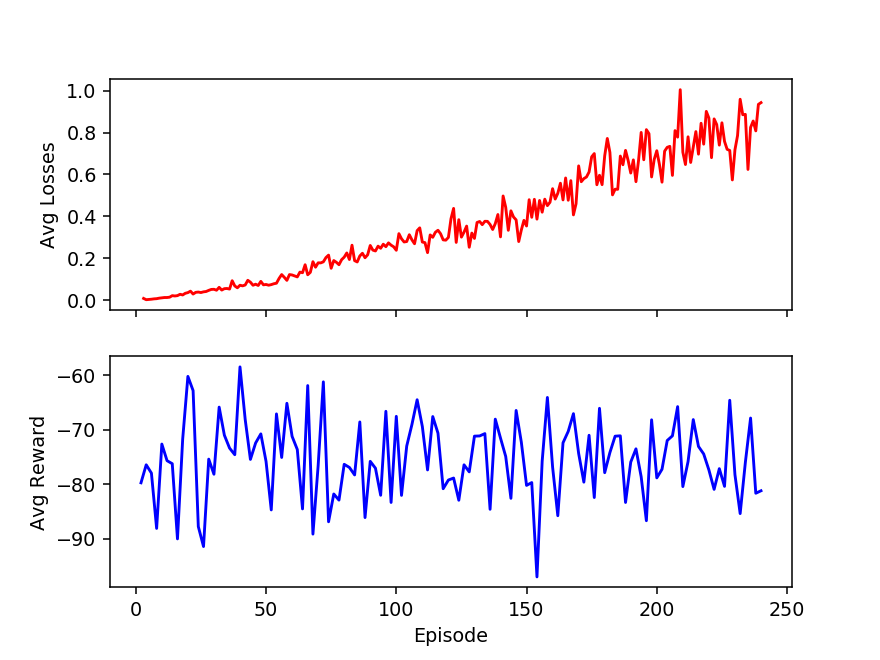

In [15]:
# plot torch results
fig, (ax1,ax2) = plt.subplots(2,sharex=True)
ax1.plot(stats['losses_ep'],stats['losses'],'r')
ax2.plot(stats['rewards_ep'], stats['rewards'],'b')
ax1.set_ylabel('Avg Losses')
ax2.set_ylabel('Avg Reward')
ax2.set_xlabel('Episode')
plt.show()

Torch net isn't learning

In [14]:
# save torch net params - using pickle
torch.save(net, PATH_ROOT + 'saved_net')
torch.save(target_net, PATH_ROOT + 'saved_target_net')

pickle.dump(memory,file(PATH_ROOT + 'saved_memory','w'))
pickle.dump(noise,file(PATH_ROOT + 'saved_noise','w'))
for n in stats:
    np.save(PATH_ROOT + n, np.array(stats[n]))
    

/root/anaconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ActorCriticNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ActorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type CriticNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [6]:
# load tf net (restoring saved parameters)
dtf = ddpg_tf.DDPG_TF(env,loadfilename='tf_params-0',printVars=False)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-08-16 09:05:06,280] From /root/anaconda2/lib/python2.7/site-packages/tensorflow/python/util/tf_should_use.py:170: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-08-16 09:05:06,723] From /root/anaconda2/lib/python2.7/site-packages/tensorflow/python/util/tf_should_use.py:170: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


INFO:tensorflow:Restoring parameters from tf_params-0


[2017-08-16 09:05:07,007] Restoring parameters from tf_params-0


restore complete


In [7]:
# load control data, and tf net results
control_states = np.load('control_states.npy')[::4]
control_rewards = np.load('control_rewards.npy')[::4]
tf_record = np.load('tf_control_record.npy')

#print tf_record
def calc_error(a,b):
    return np.sqrt(np.sum((a-b)**2))

In [8]:
# replace torch params with tf params, and run control data, collecting torch net results
# first optimization step will occur at i == 50, upon which extra data is recorded to compare tf and torch
# using: no bn, REPLAY_BUFFER_SIZE=200, REPLAY_START_SIZE=50, BATCH_SIZE=50, constant replay_buffer_batches (always the most recent experiences)
replaceNetParams(dtf, net, target_net)

copy_net = copy.deepcopy(net)

torch_record = []

stepped = -1
first_step = True

for i in xrange(len(control_rewards)-1):
    state = torch.from_numpy(control_states[i].reshape(1,state_dim)).float()
    action = net.getAction(Variable(state)).data
    target_action = target_net.getAction(Variable(state)).data
    
    reward = torch.FloatTensor([[control_rewards[i]]]).float()

    new_state = torch.from_numpy(control_states[i+1].reshape(1,state_dim)).float()
    
    memory.add(state,action,reward,new_state,True)
    if memory.count() > REPLAY_START_SIZE:
        minibatch = memory.get_batch(BATCH_SIZE)
        state_batch = torch.cat([data[0] for data in minibatch],dim=0)
        action_batch = torch.cat([data[1] for data in minibatch],dim=0)
        reward_batch = torch.cat([data[2] for data in minibatch])
        next_state_batch = torch.cat([data[3] for data in minibatch],dim=0)
        done_batch = Tensor([data[4] for data in minibatch])

        # calculate y_batch from targets
        #next_action_batch = target_net.getAction(Variable(next_state_batch))
        value_batch = target_net.getValue(Variable(next_state_batch)).data
        y_batch = reward_batch + GAMMA * value_batch * done_batch
        
        if first_step:
            print 'first step complete'
            torch_ys = y_batch
            torch_batch = minibatch
            torch_outs = net.getValue(Variable(state_batch)).data
            first_step = False

        # optimize net 1 step
        loss = criterion(net.getValue(Variable(state_batch)), Variable(y_batch))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stepped = loss.data[0]

        # update targets - using exponential moving averages
        for group, target_group in zip(optimizer.param_groups, target_optim.param_groups):
            for param, target_param in zip(group['params'], target_group['params']):
                target_param.data.mul_(1 - TAU)
                target_param.data.add_(TAU, param.data)
                
        
    
    torch_record.append([action.numpy()[0][0], target_action.numpy()[0][0],stepped])
    stepped = -1

torch_record = np.array(torch_record)
torch_outs = torch_outs.numpy().T[0]
torch_ys = torch_ys.numpy().T[0]
print torch_record[:5]


first step complete
[[  2.95158988e-03   8.21625406e-04  -1.00000000e+00]
 [  1.45499164e-03  -5.40858076e-04  -1.00000000e+00]
 [  2.10465165e-03  -2.31159315e-03  -1.00000000e+00]
 [ -1.51440373e-03  -5.43833943e-03  -1.00000000e+00]
 [  4.29392513e-03  -2.26005664e-04  -1.00000000e+00]]


In [9]:
# compare torch and tf results
# results for each net have 3 columns: [net action prediction, target net action prediction, loss (-1 if there was no training)]
if len(torch_record) == 50:
    print calc_error(tf_record[:50,:], torch_record)
    #print np.hstack([tf_record[:50,:], torch_record])
    print (torch_record[:,0] - tf_record[:50,0]) / torch_record[:,0]
else:
    sel = np.arange(40,60)
    print calc_error(tf_record[sel,:], torch_record[sel,:])
    print np.hstack([tf_record[sel,:], torch_record[sel,:]])

3.89995250567
[[  1.21020654e-03  -2.76387087e-03  -1.00000000e+00   1.21020724e-03  -2.76387203e-03  -1.00000000e+00]
 [  3.88946873e-03  -6.97110896e-04  -1.00000000e+00   3.88946966e-03  -6.97110547e-04  -1.00000000e+00]
 [ -2.13962674e-04  -2.37000128e-03  -1.00000000e+00  -2.13961350e-04  -2.37000245e-03  -1.00000000e+00]
 [ -2.24312724e-04  -2.90539605e-03  -1.00000000e+00  -2.24312462e-04  -2.90539605e-03  -1.00000000e+00]
 [ -2.23430060e-03  -5.90191549e-03  -1.00000000e+00  -2.23430037e-03  -5.90191735e-03  -1.00000000e+00]
 [  9.54222487e-05  -3.55583918e-03  -1.00000000e+00   9.54214483e-05  -3.55583848e-03  -1.00000000e+00]
 [  3.19631142e-03  -2.58903368e-03  -1.00000000e+00   3.19631211e-03  -2.58903438e-03  -1.00000000e+00]
 [  3.03525198e-03  -1.55804341e-03  -1.00000000e+00   3.03525175e-03  -1.55804318e-03  -1.00000000e+00]
 [  5.39657893e-03  -1.43377297e-03  -1.00000000e+00   5.39657939e-03  -1.43377460e-03  -1.00000000e+00]
 [  4.06514155e-03  -2.35379659e-04  -1.0

In [13]:
# load all tf results from before taking first optimization step
tf_ys = np.load('tf_first_step_y_batch.npy')
tf_rs = np.load('tf_first_step_reward_batch.npy')
tf_ds = np.load('tf_first_step_done_batch.npy')
tf_vs = np.load('tf_first_step_value_batch.npy')
tf_outs = np.load('tf_first_step_output_values.npy')
torch_wd = 1.36607 # weight decay loss of tf net at first optimization step - recorded directly from terminal output of tf net

In [24]:
# compare tf and torch data from before taking first optimization step
# including calculation of manual loss
print 'ys', calc_error(torch_ys, tf_ys)
print 'outs', calc_error(torch_outs, tf_outs)
print 'torch manual loss', np.mean((torch_ys - torch_outs)**2)
print 'tf manual loss', np.mean((tf_ys - tf_outs)**2)
print 'torch loss', torch_record[50,2]
print 'tf loss', tf_record[50,2] - torch_wd

ys 1.6686e-08
outs 1.00415e-08
torch manual loss 0.331399
tf manual loss 0.331399
torch loss 0.331398844719
tf loss 0.331403049164


In [13]:
#ignore
# comparison of torch params after first optimization step and tf params after first optimization step, with the same initial params
#dtf_fs = ddpg_tf.DDPG_TF(env,loadfilename='tf_params-50',printVars=False)
"""
ls = []

ls.append(net.getAction(Variable(torch.from_numpy(control_states).float())).data.numpy()) # original
ls.append(target_net.getAction(Variable(torch.from_numpy(control_states).float())).data.numpy()) # original target

ls.append(dtf_fs.actions(control_states))
ls.append(dtf_fs.target_actions(control_states))

#replaceNetParams(dtf, net, target_net)


#ls.append(net.getAction(Variable(torch.from_numpy(control_states).float())).data.numpy())
#ls.append(target_net.getAction(Variable(torch.from_numpy(control_states).float())).data.numpy())

results = np.hstack(ls)
#print 'load successful' if np.sum((results[:,2]-results[:,4])**2) < 1e-10 else 'load failed'
#print
print results"""
pass

In [10]:
#print copy_net.getAction(Variable(torch.from_numpy(control_states[0].reshape(1,state_dim)).float())).data.numpy()
#print net.getAction(Variable(torch.from_numpy(control_states[0].reshape(1,state_dim)).float())).data.numpy()

In [11]:
#print net.getAction(Variable(torch.from_numpy(control_states[0].reshape(1,state_dim)).float())).grad

In [ ]:
# find reward space for pendulum gym problem using search
min_reward = -16.2723932378 #100000
max_reward = -3.02107336922e-05 #-100000

In [ ]:
# search for min and max reward in pendulum problem
test_env = gym.make('Pendulum-v0')
for e in range(1000):
    #print 'episode', e
    test_env.reset()
    for _ in range(100):
        _,reward,done,_ = test_env.step(test_env.action_space.sample()) # take a random action
        if reward > max_reward: max_reward = reward
        if reward < min_reward: min_reward = reward
        if done: break
print min_reward, max_reward

<IPython.core.display.Javascript object>


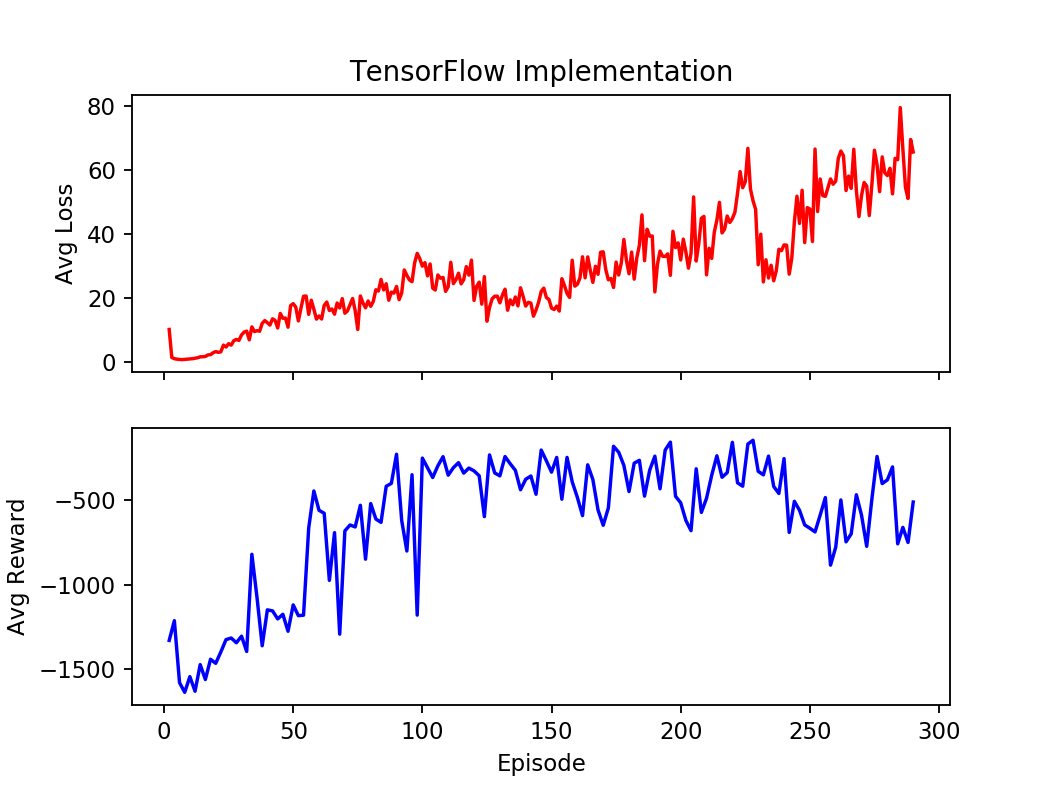

In [8]:
# tensorflow result comparison
# solving the problem takes about 100 episodes.
# using: no bn, REPLAY_BUFFER_SIZE=5000, REPLAY_START_SIZE=500, BATCH_SIZE=64, LR=(Actor=1e-4,Critic=1e-3)
fig, (ax1,ax2) = plt.subplots(2,sharex=True)
ax1.set_title('TensorFlow Implementation')
ax1.plot(np.load('tf_stat_losses_ep_long.npy'),np.load('tf_stat_losses_long.npy'),'r')
ax2.plot(np.load('tf_stat_rewards_ep_long.npy'), np.load('tf_stat_rewards_long.npy'),'b')
ax1.set_ylabel('Avg Loss')
ax2.set_ylabel('Avg Reward')
ax2.set_xlabel('Episode')
plt.show()

Tf net solved problem after about 100 episodes